In [1]:
import os
import glob
import pandas as pd
from pathlib import Path
import numpy as np
import scipy.spatial.distance as dist
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets

# Definitions

In [2]:
class DataSetLoader:
    
    # Distance Functions
    # TODO: Add more kernel types
    def euclideanDistance(self, p1, p2):
        return np.linalg.norm(p1-p2, ord=2)
    
    
    def adjacencyMatrix_xy(self, data_df, distFunc):
        if 'x' not in data_df.columns.str.lower() or 'y' not in data_df.columns.str.lower():
            raise Exception("Columns 'x' or 'y' not found in data")
        data = data_df.copy()
        data.columns = data.columns.str.lower()
        points = data[['x','y']].to_numpy()
        n = len(points)
        adjMat = np.matrix(np.zeros((n,n)))
        for i in range(n):
            if i % 100 == 0:
                print(f'{i}/{n}', end='\r')
            for j in range(i+1,n):
                dist = dsl.euclideanDistance(points[i],points[j])
                adjMat[i,j] = dist
                adjMat[j,i] = dist
        print('Done                         ')
        return adjMat
        
    #Plotting Function
    def plot2D(self, data_df, colorList, **kwargs):
        plt.scatter(data_df.x, data_df.y, c=colorList, **kwargs)
        plt.show()
    
    #Instance Functions
    
    def checkDataSource(self, dsType, dsName):
        if dsType not in self.dataSet_dict:
            raise Exception("Invalid Data Source Type",dsType)
        if dsName not in self.dataSet_dict[dsType]:
            raise Exception(f"Data Source {dsName} of type {dsType} not found")
        
    def arrayToDf(self,generatedArray):
         return pd.DataFrame([{'x':generatedArray[0][i][0], 'y':generatedArray[0][i][1], 'color':generatedArray[1][i]} for i in range(len(generatedArray[1]))])
        
    def load(self, dsType, dsName, **kwargs):
        self.checkDataSource(dsType, dsName)
        dsDict = self.dataSet_dict[dsType][dsName]
        if dsDict['loadingFunc'] == pd.read_csv:
            return dsDict['loadingFunc'](dsDict['FilePath'], **kwargs)
        elif dsDict['loadingFunc'] == self.arrayToDf:
            return self.arrayToDf(dsDict['generatorFunc'](**kwargs))
        else:
            return dsDict['loadingFunc'](**kwargs)
    
    def plot(self, dsType, dsName, clusterIndexList = None, **kwargs):
        data_df = self.load(dsType,dsName)
        if clusterIndexList is None:
            self.plot2D(data_df, data_df.color.to_list(), **kwargs)
        else:
            self.plot2D(data_df, clusterIndexList, **kwargs)
        
    def staticDef(self):
        self.dsType_similarityMetric_dict = {
            'SKLearn':self.euclideanDistance,
            'BasicColors': self.euclideanDistance,
            'RandomMultiDim': self.euclideanDistance
        }

        self.dsType_plottingFunction_dict = {
            'SKLearn': self.plot2D,
            'BasicColors': self.plot2D,
            'RandomMultiDim': None
        }
    
    def computeAccuracy(self, truth_df, predictedLabels):
        if len(predictedLabels) != truth_df.shape[0]:
            raise Exception('Dataset and predicted labels must be same size')
        copy_df = truth_df.copy()
        copy_df['raw_prediction'] = predictedLabels
        mappedPred = {}
        for t in copy_df.color.unique():
            pred_mode = copy_df[(copy_df.color == t) & (~copy_df.raw_prediction.isin(list(mappedPred)))].raw_prediction.mode().iloc[0]
            mappedPred[pred_mode] = t
        copy_df['mapped_prediction'] = copy_df.raw_prediction.map(mappedPred)
        correct_predictions = copy_df[copy_df.color == copy_df.mapped_prediction].shape[0]
        return correct_predictions/len(predictedLabels)
    
    def __init__(self, dataset_root):

        self.staticDef()
        
        self.dataSet_dict = {}

        
        skLearnDatasetDict = {
            'moons':{
                    'generatorFunc':datasets.make_moons,
                    'similarityFunc':self.dsType_similarityMetric_dict['SKLearn'],
                    'plottingFunc':self.dsType_plottingFunction_dict['SKLearn'],
                    'loadingFunc':self.arrayToDf,
                    },
            'circles':{
                    'generatorFunc':datasets.make_circles,
                    'similarityFunc':self.dsType_similarityMetric_dict['SKLearn'],
                    'plottingFunc':self.dsType_plottingFunction_dict['SKLearn'],
                    'loadingFunc':self.arrayToDf,
                    },
            'blobs':{
                    'generatorFunc':datasets.make_blobs,
                    'similarityFunc':self.dsType_similarityMetric_dict['SKLearn'],
                    'plottingFunc':self.dsType_plottingFunction_dict['SKLearn'],
                    'loadingFunc':self.arrayToDf,
                    }

        }
        self.dataSet_dict['sklearn'] = skLearnDatasetDict

        
        dataSetTypes = glob.glob(f'{dataset_root}/*')
        for fol in dataSetTypes:
            if 'MNIST' not in fol:
                dsType = Path(fol).stem
                dsType_dict = {}
                for ds in glob.glob(f'{fol}/*.csv'):
                    dsPath = Path(ds)
                    dsName = dsPath.stem
                    absPath = dsPath.absolute()
                    dsType_dict[dsName] = {
                        'FilePath':absPath,
                        'similarityFunc':self.dsType_similarityMetric_dict[dsType],
                        'plottingFunc':self.dsType_plottingFunction_dict[dsType],
                        'loadingFunc':pd.read_csv,
                    }
                self.dataSet_dict[dsType] = dsType_dict


In [3]:
class SpectralClustering:
    
    def __init__(self, adjMat, sigma = 1):
        self.adjacency_matrix = adjMat
        self.W = np.exp(-adjMat/(2*sigma))
        self.D = np.diag(np.asarray(np.sum(self.W, axis=1)).flatten())
        self.L = self.D - self.W

    # TODO: Create functions for normalized/unnormalized algo and add parameters
    # TODO: add parameters for Eigen solver and add options for linalg and cheb-dev
    # TODO: add options for trimming similarity graph based on knn, epsilon etc. 
    def getClusters(self, k):
        D_inv = np.diag(1/np.diag(self.D))
        eigVal, eigVec = np.linalg.eig(np.dot(D_inv, self.L))
        idx = eigVal.argsort()
        idxToSel = []
        currIdx = 0
        while len(idxToSel) < k:
            if eigVal[currIdx] > 0: #1e-10:
                idxToSel.append(currIdx)
            currIdx += 1
        k_eigVec = eigVec[:, idxToSel]
        kmeans = KMeans(n_clusters=k, random_state=31).fit(k_eigVec) 
        return kmeans.labels_


# Initializations

In [4]:
dsl = DataSetLoader('../../DataSets/')

Done                         


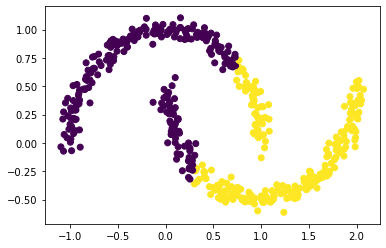

In [5]:
data_df = dsl.load('sklearn','moons',n_samples=500, noise=0.05, random_state=31)
adjMat = dsl.adjacencyMatrix_xy(data_df,dsl.euclideanDistance)
moons_sc = SpectralClustering(adjMat)
clusters = moons_sc.getClusters(k=2)
plt.scatter(data_df.x, data_df.y, c=clusters)


In [6]:
dsl.computeAccuracy(data_df,clusters)

0.75

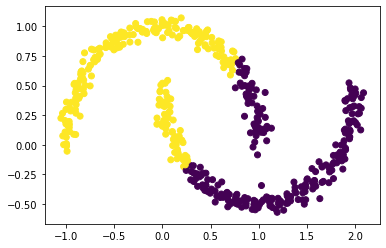

115

In [7]:
from sklearn.cluster import SpectralClustering as SC
moons = datasets.make_moons(n_samples=500, noise=0.05)
moons_x = [m[0] for m in moons[0]]
moons_y = [m[1] for m in moons[0]]
moons_label = moons[1]
clusters = SC(n_clusters=2).fit(moons[0])
plt.scatter(moons_x, moons_y, c = clusters.labels_)
plt.show()

np.sum(moons_label==clusters.labels_)

In [8]:
dsl.computeAccuracy(dsl.arrayToDf(moons),clusters.labels_)

0.77

Done                         


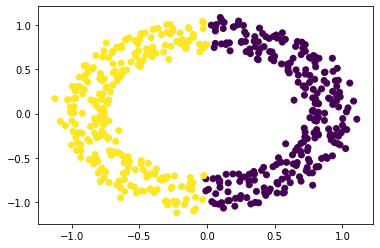

Accuracy:  0.506


In [10]:
data_df = dsl.load('sklearn','circles',n_samples=500, noise=0.05, random_state=31)
adjMat = dsl.adjacencyMatrix_xy(data_df,dsl.euclideanDistance)
moons_sc = SpectralClustering(adjMat)
clusters = moons_sc.getClusters(k=2)
plt.scatter(data_df.x, data_df.y, c=clusters)
plt.show()
print("Accuracy: ", dsl.computeAccuracy(data_df, clusters))

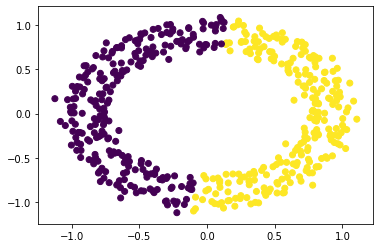

In [13]:
from sklearn.cluster import SpectralClustering as SC
moons = datasets.make_circles(n_samples=500, noise=0.05, random_state=31)
moons_x = [m[0] for m in moons[0]]
moons_y = [m[1] for m in moons[0]]
moons_label = moons[1]
clusters = SC(n_clusters=2).fit(moons[0])
plt.scatter(moons_x, moons_y, c = clusters.labels_)
plt.show()

In [14]:
dsl.computeAccuracy(data_df,clusters.labels_)

0.5

# Scratch

Shape Data: (3192, 3)


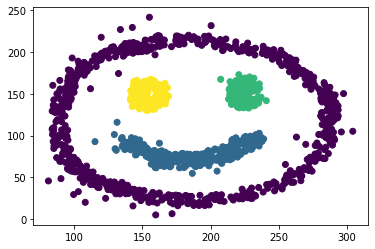

In [16]:
dataDf = dsl.load('BasicColors','basic2')
print("Shape Data:", dataDf.shape)
adjMat = dsl.adjacencyMatrix_xy(dataDf, dsl.euclideanDistance)


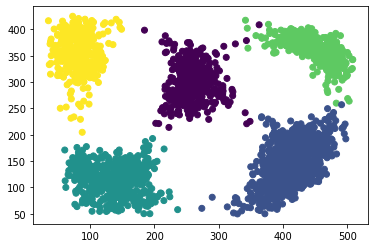

In [32]:
dsl.plot('BasicColors','network')

Done                         


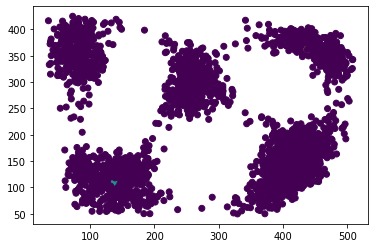

IndexError: single positional indexer is out-of-bounds

In [34]:
data_df = dsl.load('BasicColors','network')
adjMat = dsl.adjacencyMatrix_xy(data_df,dsl.euclideanDistance)
moons_sc = SpectralClustering(adjMat)
clusters = moons_sc.getClusters(k=5)
plt.scatter(data_df.x, data_df.y, c=clusters)
plt.show()
print("Accuracy: ", dsl.computeAccuracy(data_df, clusters))

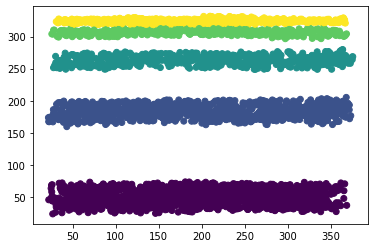

In [83]:
dsl.plot('BasicColors','lines', marker='o')

In [87]:
sc = SpectralClustering(adjMat)
clusters = sc.getClusters(4)
clusters

array([0, 0, 0, ..., 0, 0, 0])

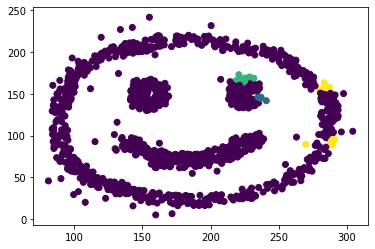

In [88]:
plt.scatter(dataDf.x, dataDf.y, c=clusters)
plt.show()


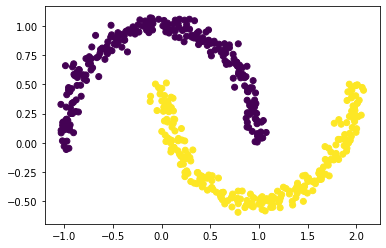

In [111]:
moons = datasets.make_moons(n_samples=500,noise=0.05,random_state=30)
moons_x = [m[0] for m in moons[0]]
moons_y = [m[1] for m in moons[0]]
moons_label = moons[1]
plt.scatter(moons_x, moons_y, c = moons_label)

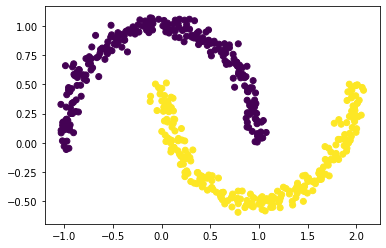

In [33]:
moons = dsl.load('sklearn', 'moons',n_samples=500,noise=0.05,random_state=30)
moons_x = [m[0] for m in moons[0]]
moons_y = [m[1] for m in moons[0]]
moons_label = moons[1]
plt.scatter(moons_x, moons_y, c = moons_label)

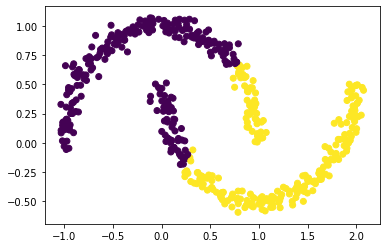

In [119]:
from sklearn.cluster import SpectralClustering as SC

clusters = SC(n_clusters=2).fit(moons[0])
plt.scatter(moons_x, moons_y, c = clusters.labels_)
plt.show()

In [48]:
D_inv = np.diag(1/np.diag(sc.D))
# Compute the eigenpairs of L_{rw}
Lambdas, V = np.linalg.eig(np.dot(D_inv, sc.L))
Lambdas

array([0.13930225, 0.13191274, 0.12083106, ..., 0.81676192, 0.81683452,
       0.8165609 ])

In [55]:
Lambdas[:50]

array([0.13930225, 0.13191274, 0.12083106, 0.11574803, 0.11266681,
       0.10615695, 0.11132545, 0.10843498, 0.09494025, 0.10175413,
       0.08248645, 0.09561712, 0.08196525, 0.08544453, 0.08486827,
       0.09660891, 0.09126296, 0.07376045, 0.04608078, 0.06949065,
       0.05212536, 0.04605072, 0.04328385, 0.04373027, 0.06779261,
       0.068003  , 0.04172203, 0.0416664 , 0.03923842, 0.03801276,
       0.0614347 , 0.03365021, 0.03386991, 0.03189942, 0.03107999,
       0.03113974, 0.0611448 , 0.02529007, 0.0213167 , 0.01891183,
       0.02446131, 0.01820516, 0.01777344, 0.02213711, 0.0256978 ,
       0.01482712, 0.01380849, 0.01410396, 0.01184515, 0.02700779])

In [57]:
eigenValues = Lambdas[idx]
eigenVectors = V[:,idx]
eigenValues

array([2.10025512e-17, 1.87622920e-07, 3.85734663e-07, ...,
       9.88598337e-01, 9.91508612e-01, 9.93749173e-01])

In [59]:
idx[:5]

array([82, 83, 85, 84, 77], dtype=int64)

In [60]:
V[:,[83,85,84]]

matrix([[-0.0897454 ,  0.01663788,  0.00516765],
        [ 0.00424097, -0.02185737, -0.02445522],
        [ 0.0075556 , -0.03255149,  0.06431523],
        ...,
        [ 0.01716006,  0.03919618,  0.00394939],
        [ 0.00429902, -0.02178672, -0.02445004],
        [ 0.00428577, -0.02186615, -0.02421331]])

In [61]:
V

matrix([[-5.01458888e-02,  7.86623993e-02,  4.67167320e-08, ...,
          1.04284360e-15,  1.75334984e-17, -2.98237227e-16],
        [-2.16885460e-07, -5.68711676e-07, -7.27357542e-02, ...,
          7.16560226e-16,  1.24344673e-16, -7.64128486e-18],
        [-1.70721496e-11, -1.84930229e-11,  3.38369757e-10, ...,
         -1.26000427e-16, -6.84064230e-16, -2.28341157e-13],
        ...,
        [ 1.74938419e-09, -4.03033341e-09, -1.90518132e-10, ...,
         -1.85574074e-13, -1.71065023e-14,  1.72924396e-15],
        [ 2.17712471e-11,  3.73391523e-12,  2.80952074e-04, ...,
          1.65436965e-15,  4.32515852e-08, -4.57358120e-17],
        [-2.67049490e-08,  9.20448202e-09,  2.88525681e-05, ...,
          3.68707421e-14,  1.57929369e-14,  5.47180858e-08]])

In [63]:
V[:,[2,1]]

matrix([[ 4.67167320e-08,  7.86623993e-02],
        [-7.27357542e-02, -5.68711676e-07],
        [ 3.38369757e-10, -1.84930229e-11],
        ...,
        [-1.90518132e-10, -4.03033341e-09],
        [ 2.80952074e-04,  3.73391523e-12],
        [ 2.88525681e-05,  9.20448202e-09]])

In [21]:
f1 = pd.read_csv
f2 = pd.read_csv
f1==f2

True

In [22]:
f1 == pd.read_csv

True